In [1]:
opp_dirs = {
    'N': 'S',
    'S': 'N',
    'E': 'W',
    'W': 'E'
}

In [2]:
from collections import deque

In [3]:
def sort_nodes(a, b):
    if a.dist > b.dist:
        return a
    if b.dist > a.dist:
        return b
    if a.pos[0] > b.pos[0]:
        return a
    if b.pos[0] > a.pos[0]:
        return b
    if a.pos[1] > b.pos[1]:
        return a
    if b.pos[1] > a.pos[1]:
        return b

In [4]:
class Node():
    def __init__(self, pos, dist):
        self.pos = pos
        self.dist = dist
        self.neighbours = {}
        self.last_dir = ' '
        self.shortest_neighbours = set()

    def __repr__(self):
        return f'Node at pos {self.pos}'

    def add_neighbour(self, n, dist, dir):
        edge = Edge(dist, self, n, dir)
        self.neighbours[n] = edge
        # edge = Edge(dist, self, n, opp_dirs[dir])
        n.neighbours[self] = edge

class Edge():
    def __init__(self, length, n1, n2, dir):
        self.n1 = n1
        self.n2 = n2
        self.length = length
        self.dir = dir

    def __repr__(self):
        return f'{self.n1} -> {self.n2}: {self.length}'

In [5]:
dir_map = {
    'N': (0, -1),
    'S': (0, 1),
    'W': (-1, 0),
    'E': (1, 0)
}

In [6]:
import numpy as np

In [7]:
def dir_rot(a, b):
    if a == b:
        return 0
    if opp_dirs[a] == b:
        return 2
    return 1

In [8]:
grid = []
# with open("test_input.txt") as fh:
with open("input.txt") as fh:
# with open("test2.txt") as fh:
    for y, line in enumerate(fh.readlines()):
        row = []
        for x, c in enumerate(line.strip()):
            if c == 'S':
                start = (x, y)
                c = '.'
            if c == 'E':
                end = (x, y)
                c = '.'
            row.append(c)
        grid.append(row)


In [9]:
nodes: list[Node] = []
for y, row in enumerate(grid):
    for x, c in enumerate(row):
        if c == '.':
            v, h = 0, 0
            for dir in ['N', 'S', 'W', 'E']:
                nx, ny = x + dir_map[dir][0], y + dir_map[dir][1]
                if 0 < nx < len(row) and 0 < ny < len(grid):
                    if grid[ny][nx] == '.':
                        if dir in ['N', 'S']:
                            v += 1
                        else:
                            h += 1
            if v > 0 and h > 0 or (v + h) == 1:
                nodes.append(Node((x, y), np.inf))
                        
            
all_node_pos = {node.pos: node for node in nodes}
for node_pos, node in all_node_pos.items():
    for dir in ['N', 'S', 'W', 'E']:
        tile = '.'
        dist = 0
        nx, ny = node_pos
        while tile == '.':
            nx, ny = nx + dir_map[dir][0], ny + dir_map[dir][1]
            if 0 > nx >= len(grid[0]) or 0 > ny >= len(grid):
                break
            tile = grid[ny][nx]
            dist += 1
            if tile == '#':
                break
            elif (nx, ny) in all_node_pos:
                node.add_neighbour(all_node_pos[(nx, ny)], dist, dir)
                break

In [10]:
unvisited = all_node_pos.copy()
# last_dir = 'E'
for node in all_node_pos.values():
    node.dist = np.inf
    node.last_dir = ' '

node = all_node_pos[start]
node.dist = 0

while True:
    node = sorted(unvisited.values(), key=lambda x: x.dist)[0]
    del(unvisited[node.pos])
    dist = node.dist
    # if node.pos == end:
    #     break
    for neighbour, edge in node.neighbours.items():
        last_dir = node.last_dir if node.last_dir != ' ' else 'E'
        score = dist + (edge.length + (dir_rot(last_dir, edge.dir) * 1000))
        if score < neighbour.dist:
            neighbour.dist = score
            neighbour.last_dir = edge.dir
    # end_nodes_left = [x for x in all_node_pos[end].neighbours if x.pos in unvisited]
    if len(unvisited) == 0:
        break

In [11]:
unvisited = all_node_pos.copy()
# last_dir = 'E'
for node in all_node_pos.values():
    node.dist = np.inf
    node.last_dir = ' '
    node.prev = set()

node = all_node_pos[start]
node.dist = 0
queue = deque(all_node_pos.values())

while len(queue) > 0:
    node = sorted(queue, key=lambda x: x.dist)[0]
    queue.remove(node)
    dist = node.dist
    for neighbour, edge in node.neighbours.items():
        last_dir = node.last_dir if node.last_dir != ' ' else 'E'
        score = dist + (edge.length + (dir_rot(last_dir, edge.dir) * 1000))
        if score < neighbour.dist:
            neighbour.prev = set()
            neighbour.prev.add(node)
            neighbour.dist = score
            neighbour.last_dir = edge.dir
            node.prev.add(neighbour)
        elif score == neighbour.dist:
            neighbour.prev.add(node)

In [12]:
from PIL import Image, ImageDraw, ImageOps

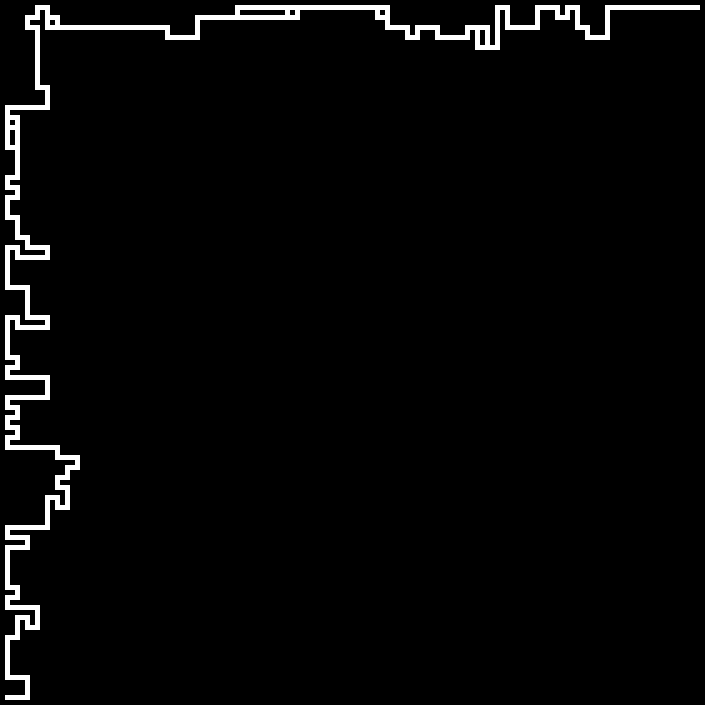

526


In [13]:
end_node = all_node_pos[end]
total_good_pos = 1
last_dist = end_node.dist
queue = [end_node]

seen_edges = set()
seen_nodes = set()
seen_nodes.add(end_node)

image = Image.new('RGB', (len(grid), len(grid[0])))
draw = ImageDraw.Draw(image)

edges_to_count = set()
while len(queue) > 0:
    node = sorted(queue, key=lambda x: x.dist)[0]
    queue.remove(node)
    for nnode, edge in node.neighbours.items():
        if node == end_node:
            shortest_neighbour = sorted(node.neighbours.keys(), key=lambda x: x.dist)[0]
            if nnode != shortest_neighbour:
                continue
        if nnode.dist > node.dist:
            continue
        # print(nnode.dist, node.dist)
        if edge not in seen_edges:
            # Image draw line between nodes
            draw.line([node.pos, nnode.pos], fill=(255, 255, 255), width=1)

            queue.append(nnode)
            seen_edges.add(edge)
            edges_to_count.add(edge)
            total_good_pos += edge.length if nnode not in seen_nodes else edge.length - 1
            seen_nodes.add(nnode)

            # print(f'{edge}: total {total_good_pos}')

display(ImageOps.scale(image, 5, resample=0))

print(total_good_pos)



In [ ]:
# This number is wrong - there are two squares at the top that should not be counted. 520 is the correct answer by visual check.